In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from Microscale_synthetic_data_generator import DataGenerator
from lmfit import minimize, Parameters, fit_report
from scipy.constants import N_A
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

In [2]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10*10
t = np.geomspace(1e-10, t_end, 15)
tspan = [1e-10, t_end]
z0 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [3]:
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    Atot = well_size*N_A*Ainit/Target_cell_number
    express = (-2*Atot*k1*Ainit*(rtot - x)*(koff*rtot + k2*x) + x*(((koff*rtot + k2*x)**2) +k1*Ainit*(rtot - x)*(2*koff*rtot + k2*(rtot+x))))/((koff*rtot + k2*x)**2)

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff*rtot + k2*x))

    return express

In [45]:
t_end = 60*60*10*1000
t = np.geomspace(1e-10, t_end, 15)
tspan = [1e-10, t_end]

A0s = np.geomspace(1e-12, 1e-5, 50)

param_dict = {
    'rtot': 1e5,
    'kon': 1e5,
    'koff': 1e-4,
    'k2': 1e2,
    't_eval': t,
    't_span': tspan
}

data_generator = DataGenerator(param_dict)

#data = np.asarray([A1, A2])
#data = data.flatten()

def model_S(t, z, Ainit, rtot, kon, koff, k2):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def solve_ode_time(params, A0, t=t):
     

    rtot = params[f'rtot']
    kon = params[f'kon']
    k2 = params[f'k2']
    koff = params[f'koff']


    z = solve_ivp(model_S, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot, kon, koff, k2))
        
    A10 = z.y[0]
    A11 = z.y[1]
    sol = np.asarray([A10, A11])
 
    return sol

def solve_ode_stst(params, A0s):

    rtot = params[f'rtot']
    kon = params[f'kon']
    k2 = params[f'k2']
    koff = params[f'koff']
    A10_stvals = np.zeros_like(A0s)
    A11_stvals = np.zeros_like(A0s)

    for i, A0 in enumerate(A0s):

        A10_stst = fsolve(A1_steady_state, [1e-7], args=(A0, kon, koff, k2, rtot))
        A11_stst = A2_steady_state(A10_stst, k2, koff, rtot)

        A10_stvals[i] = A10_stst
        A11_stvals[i] = A11_stst


    solll = [A10_stvals, A11_stvals]

    return solll

def objective_time(params, data, A0):
    #data = data.flatten()
    ndata = len(data)
    resid = np.zeros_like(data)
    sol = solve_ode_time(params, A0)
    A1 = sol[0]
    A2 = sol[1]
    val = (A1 + A2)
    for i in range(ndata):
        resid[i] = data[i] - val[i]
    
    return resid.flatten()

def objective_stst(params, data, A0s):

    ndata = len(data)
    resid = np.zeros_like(data)
    sol = solve_ode_stst(params, A0s)
    A10_stst = sol[0]
    A11_stst = sol[1]
    val = (A10_stst + 2*A11_stst)
    for i in range(ndata):
        resid[i] = data[i] - val[i]

    return resid


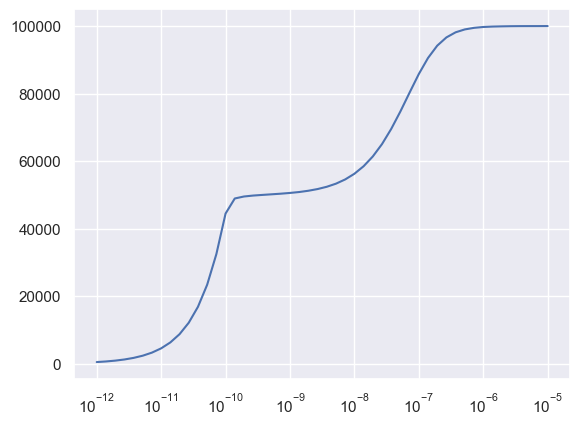

In [24]:
data = data_generator.generate_steady_states(A0s, 'model S', 0.0001)
solution = (data[0] + data[1])
plt.semilogx(A0s, solution)

In [15]:
noise_levels = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]
fits_list = []

for noise_level in noise_levels:
    vals = data_generator.generate_steady_states(A0s, 'model S', noise_level)
    data = vals[0] + vals[1]
    result_list = []
    i = 0
    while i < 500:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e4, 1e6), min=1e4, max = 1e6)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(10, 1e3), min=10, max = 1e3)
        fit_params.add(f'koff', value = np.random.uniform(1e-5, 1e-3),  min=1e-5, max = 1e-3)

        out = minimize(objective_stst, fit_params , args=(data, A0s), calc_covar=True)
        result_list.append(out)
        print(i)
        i+=1

    fits_list.append(result_list)


0
1
2
3
4
5
6
7


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
28

In [16]:
result_vals_best = np.zeros((3, len(noise_levels)))
result_vals_avg = np.zeros((3, len(noise_levels)))
result_vals_std = np.zeros((3, len(noise_levels)))
params = [f'rtot', f'k2', f'koff']
true_vals = [1e5, 1e2, 1e-4]

for q, param in enumerate(params):
        for j, outputs in enumerate(fits_list):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                #val = out.params[param].value
                val = out.chisqr
                holder[i] = val
            arg = np.argmin(holder)
            best_fit = outputs[arg]
            #best_fit = np.mean(holder)
            result_vals_best[q][j] = abs(best_fit.params[param].value - true_vals[q])/true_vals[q]

for q, param in enumerate(params):
        for j, outputs in enumerate(fits_list):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                val = out.params[param].value
                holder[i] = val
            best_fit = np.mean(holder)
            best_fit_std = np.std(holder)
            print(best_fit)
            result_vals_avg[q][j] = abs(best_fit - true_vals[q])/true_vals[q]
            result_vals_std[q][j] = best_fit_std

118314.93890134103
124272.32172433054
127220.0866434255
123699.25995767284
137137.29777743953
132764.17558144164
98.31858301169676
116.25135258261193
103.42358270127974
90.21490757113078
102.9750000313722
109.12876244678162
0.0001313200895620662
0.00025442884419512685
0.000676299109658758
0.0004227372341054744
6.45855085462734e-05
5.636339451289629e-05


{'rtot': 118314.93890134103, 'kon': 100000.0, 'k2': 101.68141698830324, 'koff': 0.0001313200895620662}
{'rtot': 100000.00058837769, 'kon': 100000.0, 'k2': 100.00000058886921, 'koff': 0.00010000019392759449}
{'rtot': 124272.32172433054, 'kon': 100000.0, 'k2': 116.25135258261193, 'koff': 0.00025442884419512685}
{'rtot': 100664.6700826937, 'kon': 100000.0, 'k2': 115.80628130717716, 'koff': 0.0002302541275772799}
{'rtot': 127220.0866434255, 'kon': 100000.0, 'k2': 103.42358270127974, 'koff': 0.000676299109658758}
{'rtot': 100537.71916944087, 'kon': 100000.0, 'k2': 106.81105101319714, 'koff': 0.0006738982743737864}


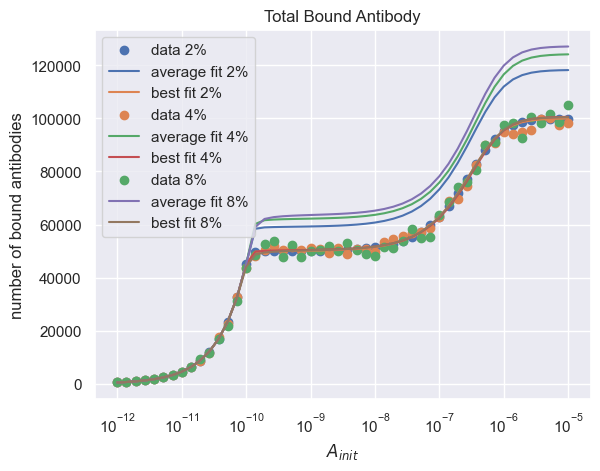

In [27]:
avg_vals = []
best_vals = []
data_vals = []
labels = [f'2%', f'4%', f'8%']
t1 = np.geomspace(1e-10, t_end, 100)
noises = [0.0, 0.04, 0.08]
sns.set_context('talk')
sns.set_theme()

for i, noise in enumerate(noises):
    rtot_avg = (result_vals_avg[0][i]*1e5) + 1e5
    k2_avg = (result_vals_avg[1][i]*1e2) + 1e2
    koff_avg = (result_vals_avg[2][i]*1e-4) + 1e-4
    params_avg = {f'rtot' : rtot_avg,
          f'kon': 1e5,
          f'k2': k2_avg,
          f'koff': koff_avg}
    print(params_avg)

    rtot_best = (result_vals_best[0][i]*1e5) + 1e5
    k2_best = (result_vals_best[1][i]*1e2) + 1e2
    koff_best = (result_vals_best[2][i]*1e-4) + 1e-4
    params_best = {f'rtot' : rtot_best,
          f'kon': 1e5,
          f'k2': k2_best,
          f'koff': koff_best}
    print(params_best)
    data = data_generator.generate_steady_states(A0s, 'model S', noise)

    data_vals.append(data[0] + data[1])


    plt.scatter(A0s, data[0]+data[1], label='data ' + labels[i])

    sol_avg = solve_ode_stst(params_avg, A0s)
    ab_avg = sol_avg[0] + sol_avg[1]

    sol_best = solve_ode_stst(params_best, A0s)
    ab_best = sol_best[0] + sol_best[1]
    plt.plot(A0s, ab_avg, label='average fit ' + labels[i])
    plt.plot(A0s, ab_best, label='best fit ' + labels[i])

plt.xscale('log')
plt.xlabel(r'$A_{init}$')
plt.title('Total Bound Antibody')
plt.ylabel('number of bound antibodies')
plt.legend()
plt.show()

In [43]:


data = np.zeros((6, 500))

param = f'koff'

for q, fit in enumerate(fits_list):
        for i, out in enumerate(fit):
            val = out.params[param].value
            data[q][i] = (val - 1e-4)/1e-4

noise_levels_array = np.zeros((6, 500))
for i, noise in enumerate(noise_levels):
    noise_levels_array[i][:] = noise

data = data.flatten()
noise_levels_array =  noise_levels_array.flatten()
d = {'noise': noise_levels_array, 'data': data}
df = pd.DataFrame(d)

Text(0.5, 1.0, '$r^{tot}$ Fitted Parameter Values ')

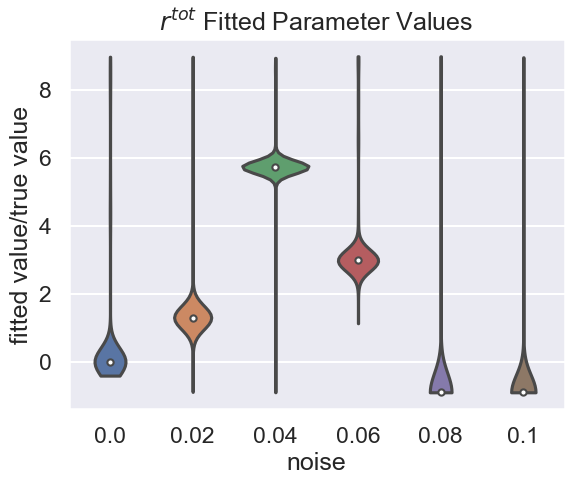

In [44]:
sns.set_context('talk')
sns.violinplot(data=df, x='noise', y='data', cut=0)
plt.ylabel('fitted value/true value')
plt.title(r'$r^{tot}$' + ' Fitted Parameter Values ')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/rtot_fitted_values_distributions.png')

In [46]:
noise_levels = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]
fits_list1 = []

for noise_level in noise_levels:
    vals = data_generator.generate_steady_states(A0s, 'model S', noise_level)
    data = vals[0] + 2*vals[1]
    result_list = []
    i = 0
    while i < 500:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e4, 1e6), min=1e4, max = 1e6)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(10, 1e3), min=10, max = 1e3)
        fit_params.add(f'koff', value = np.random.uniform(1e-5, 1e-3),  min=1e-5, max = 1e-3)

        out = minimize(objective_stst, fit_params , args=(data, A0s), calc_covar=True)
        result_list.append(out)
        print(i)
        i+=1

    fits_list1.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286


In [47]:
result_vals_best = np.zeros((3, len(noise_levels)))
result_vals_avg = np.zeros((3, len(noise_levels)))
result_vals_std = np.zeros((3, len(noise_levels)))
params = [f'rtot', f'k2', f'koff']
true_vals = [1e5, 1e2, 1e-4]

for q, param in enumerate(params):
        for j, outputs in enumerate(fits_list1):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                #val = out.params[param].value
                val = out.chisqr
                holder[i] = val
            arg = np.argmin(holder)
            best_fit = outputs[arg]
            #best_fit = np.mean(holder)
            result_vals_best[q][j] = abs(best_fit.params[param].value - true_vals[q])/true_vals[q]

for q, param in enumerate(params):
        for j, outputs in enumerate(fits_list1):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                val = out.params[param].value
                holder[i] = val
            best_fit = np.mean(holder)
            best_fit_std = np.std(holder)
            print(best_fit)
            result_vals_avg[q][j] = abs(best_fit - true_vals[q])/true_vals[q]
            result_vals_std[q][j] = best_fit_std

130936.31568910177
124572.36041469028
125723.58764286405
129225.33828462046
123229.19983303073
134089.7712395903
126.33358837849896
887.6987734503182
874.3756058526575
902.7043399092943
880.1193446664133
25.72792543956576
0.00016271693736907383
0.0002829097214413555
6.890137241823438e-05
9.970375656933506e-05
7.68898820928939e-05
0.0007208840161835692


{'rtot': 130936.31568910177, 'kon': 100000.0, 'k2': 126.33358837849896, 'koff': 0.00016271693736907383}
{'rtot': 100000.00005431374, 'kon': 100000.0, 'k2': 100.83226449585464, 'koff': 0.00010041687674477741}
{'rtot': 124572.36041469028, 'kon': 100000.0, 'k2': 887.6987734503182, 'koff': 0.0002829097214413555}
{'rtot': 100127.12726444575, 'kon': 100000.0, 'k2': 999.9966917203236, 'koff': 0.00022984025358981222}
{'rtot': 125723.58764286405, 'kon': 100000.0, 'k2': 874.3756058526575, 'koff': 0.00013109862758176565}
{'rtot': 100218.09013832718, 'kon': 100000.0, 'k2': 999.9997684554062, 'koff': 0.000189999999544093}


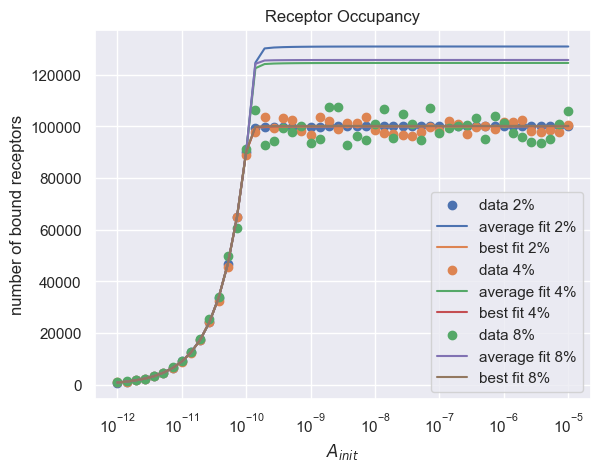

In [55]:
avg_vals = []
best_vals = []
data_vals = []
labels = [f'2%', f'4%', f'8%']
t1 = np.geomspace(1e-10, t_end, 100)
noises = [0.0, 0.04, 0.08]
sns.set_context('talk')
sns.set_theme()

for i, noise in enumerate(noises):
    rtot_avg = (result_vals_avg[0][i]*1e5) + 1e5
    k2_avg = (result_vals_avg[1][i]*1e2) + 1e2
    koff_avg = (result_vals_avg[2][i]*1e-4) + 1e-4
    params_avg = {f'rtot' : rtot_avg,
          f'kon': 1e5,
          f'k2': k2_avg,
          f'koff': koff_avg}
    print(params_avg)

    rtot_best = (result_vals_best[0][i]*1e5) + 1e5
    k2_best = (result_vals_best[1][i]*1e2) + 1e2
    koff_best = (result_vals_best[2][i]*1e-4) + 1e-4
    params_best = {f'rtot' : rtot_best,
          f'kon': 1e5,
          f'k2': k2_best,
          f'koff': koff_best}
    print(params_best)
    data = data_generator.generate_steady_states(A0s, 'model S', noise)

    data_vals.append(data[0] + 2*data[1])


    plt.scatter(A0s, data[0]+2*data[1], label='data ' + labels[i])

    sol_avg = solve_ode_stst(params_avg, A0s)
    ab_avg = sol_avg[0] + 2*sol_avg[1]

    sol_best = solve_ode_stst(params_best, A0s)
    ab_best = sol_best[0] + 2*sol_best[1]
    plt.plot(A0s, ab_avg, label='average fit ' + labels[i])
    plt.plot(A0s, ab_best, label='best fit ' + labels[i])

plt.xscale('log')
plt.xlabel(r'$A_{init}$')
plt.title('Receptor Occupancy')
plt.ylabel('number of bound receptors')
plt.legend()
plt.show()

In [58]:


data = np.zeros((6, 500))

param = f'k2'

for q, fit in enumerate(fits_list1):
        for i, out in enumerate(fit):
            val = out.params[param].value
            data[q][i] = (val - 1e2)/1e2

noise_levels_array = np.zeros((6, 500))
for i, noise in enumerate(noise_levels):
    noise_levels_array[i][:] = noise

data = data.flatten()
noise_levels_array =  noise_levels_array.flatten()
d = {'noise': noise_levels_array, 'data': data}
df = pd.DataFrame(d)

Text(0.5, 1.0, '$k_{2}$ Fitted Parameter Values ')

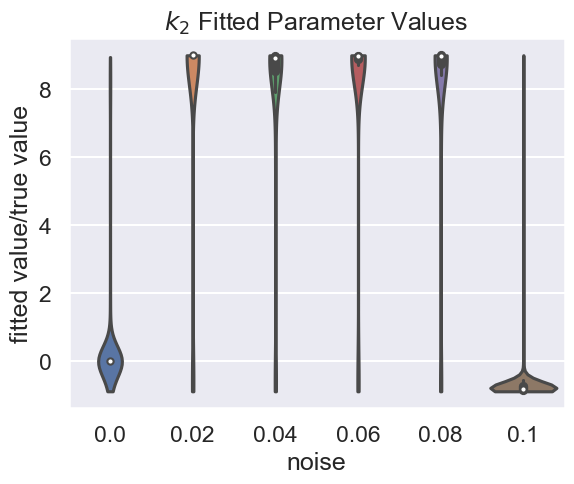

In [59]:
sns.set_context('talk')
sns.violinplot(data=df, x='noise', y='data', cut=0)
plt.ylabel('fitted value/true value')
plt.title(r'$k_{2}$' + ' Fitted Parameter Values ')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/rtot_fitted_values_distributions.png')

In [204]:
fits_list2 = []

for noise_level in noise_levels:
    data = data_generator.generate_time_series(1e-5, 'model S', noise_level)

    result_list = []
    i = 0
    while i < 500:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e4, 1e6), min=1e4, max = 1e6)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(10, 1e3), min=10, max = 1e3)
        fit_params.add(f'koff', value = np.random.uniform(1e-5, 1e-3),  min=1e-5, max = 1e-3)

        out = minimize(objective_time, fit_params, args=(data, 1e-5), calc_covar=False)
        result_list.append(out)
        print(i)
        i+=1

    fits_list2.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [205]:
fits_lists = [fits_list, fits_list1, fits_list2]
result_vals_best = np.zeros((3, 3, len(noise_levels)))
result_vals_avg = np.zeros((3, 3, len(noise_levels)))
result_vals_std = np.zeros((3, 3, len(noise_levels)))
params = [f'rtot', f'k2', f'koff']
true_vals = [1e5, 1e2, 1e-4]

for q, param in enumerate(params):
    for k, fit in enumerate(fits_lists):
        for j, outputs in enumerate(fit):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                #val = out.params[param].value
                val = out.chisqr
                holder[i] = val
            arg = np.argmin(holder)
            best_fit = outputs[arg]
            #best_fit = np.mean(holder)
            result_vals_best[q][k][j] = abs(best_fit.params[param].value - true_vals[q])/true_vals[q]

for q, param in enumerate(params):
    for k, fit in enumerate(fits_lists):
        for j, outputs in enumerate(fit):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                val = out.params[param].value
                holder[i] = val
            best_fit = np.mean(holder)
            best_fit_std = np.std(holder)
            print(best_fit)
            result_vals_avg[q][k][j] = abs(best_fit - true_vals[q])/true_vals[q]
            result_vals_std[q][k][j] = best_fit_std

259023.1695750368
424284.6492057968
159697.56056367102
181718.92397325655
520655.7305141207
113586.14097081115
132508.38279491547
137807.40163499385
141253.94014332566
136602.60315572744
136267.7553438126
139921.6866747216
103971.34044053138
104383.89541903744
105134.32545618138
107022.2331899929
107071.27207585567
108563.24476610187
551.2318868763174
196.90059268142733
202.11473203480216
195.64107065764395
138.6418940589018
308.9151892853236
423.16576957776283
419.6102066402546
433.5151226908297
384.41810280120416
582.9087512228263
363.0625162664648
241.17794415831963
448.8052776560442
94.21112357842337
910.3377239465193
805.8721383116686
893.8186038755892
0.0005006123456103422
0.0008079457619921442
0.0007967684254816703
0.0008000436642660542
0.000867109488995412
0.0006576872230603114
0.00030960559317569147
0.00031086743952328776
0.0005502659492662845
0.0004297127817859885
0.000522846397133815
0.0002735749453569044
0.00027896305994965767
0.00021736996054566923
0.0005797245050830282
0.

In [428]:
result_vals_best_st = np.zeros((3, len(noise_levels)))
result_vals_avg_st = np.zeros((3, len(noise_levels)))
params = [f'rtot', f'k2', f'koff']
true_vals = [1e5, 1e2, 1e-4]

for q, param in enumerate(params):
        for j, outputs in enumerate(fits_list):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                #val = out.params[param].value
                val = out.chisqr
                holder[i] = val
            arg = np.argmin(holder)
            best_fit = outputs[arg]
            #best_fit = np.mean(holder)
            result_vals_best_st[q][j] = abs(best_fit.params[param].value - true_vals[q])/true_vals[q]

for q, param in enumerate(params):
        for j, outputs in enumerate(fits_list):
            holder = np.zeros(500)
            for i, out in enumerate(outputs):
                val = out.params[param].value
                holder[i] = val
            best_fit = np.mean(holder)
            print(best_fit)
            result_vals_avg_st[q][j] = abs(best_fit - true_vals[q])/true_vals[q]
       

128257.71961721117
131547.8507572963
124671.38811048845
120879.85214600505
132162.23631241097
116299.3898381076
98.14765603132314
103.31154565773701
103.5900332555064
82.8810938048074
111.68546820876425
96.06483421537996
0.00014507042940769359
0.000336792662001391
0.0006369434354271263
0.00015910717254896705
0.0007285257602032243
0.0009878187029143137


{'rtot': 128257.71961721117, 'kon': 100000.0, 'k2': 101.85234396867686, 'koff': 0.00014507042940769359}
{'rtot': 100000.00058837417, 'kon': 100000.0, 'k2': 100.00000058882547, 'koff': 0.0001000001939561707}


ValueError: x and y must be the same size

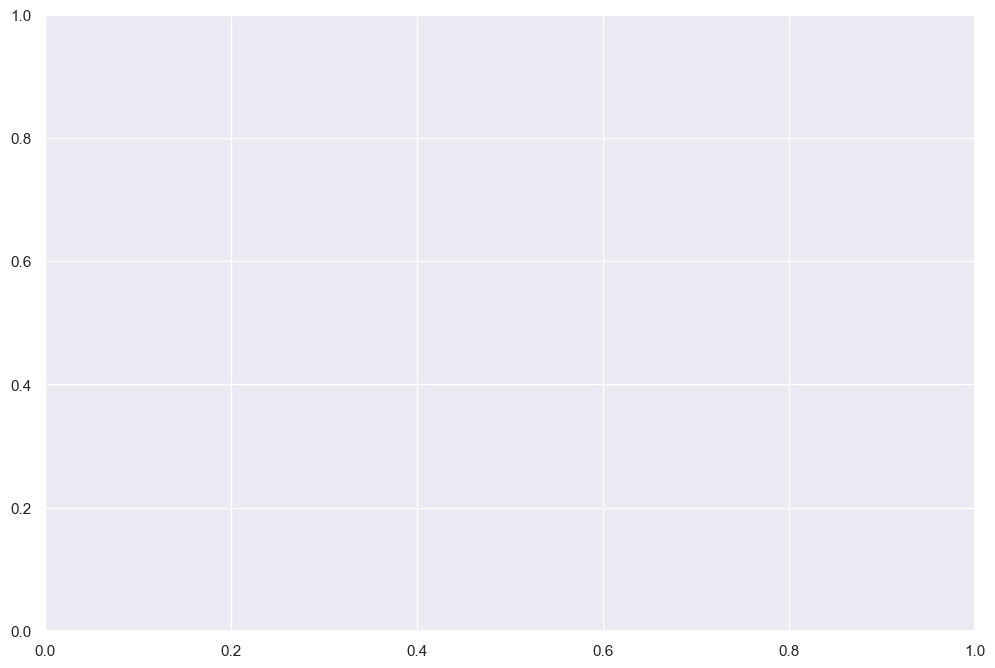

In [430]:
avg_vals = []
best_vals = []
data_vals = []
labels = [f'2%', f'4%', f'8%']
t1 = np.geomspace(1e-10, t_end, 100)
noises = [0.0, 0.04, 0.08]

for i, noise in enumerate(noises):
    rtot_avg = (result_vals_avg_st[0][i]*1e5) + 1e5
    k2_avg = (result_vals_avg_st[1][i]*1e2) + 1e2
    koff_avg = (result_vals_avg_st[2][i]*1e-4) + 1e-4
    params_avg = {f'rtot' : rtot_avg,
          f'kon': 1e5,
          f'k2': k2_avg,
          f'koff': koff_avg}
    print(params_avg)

    rtot_best = (result_vals_best_st[0][i]*1e5) + 1e5
    k2_best = (result_vals_best_st[1][i]*1e2) + 1e2
    koff_best = (result_vals_best_st[2][i]*1e-4) + 1e-4
    params_best = {f'rtot' : rtot_best,
          f'kon': 1e5,
          f'k2': k2_best,
          f'koff': koff_best}
    print(params_best)
    data = data_generator.generate_steady_states(A0s, 'model S', noise)

    data_vals.append(data[0] + data[1])


    plt.scatter(A0s, data, label='data ' + labels[i])

    sol_avg = solve_ode_stst(params_avg, A0s)
    ab_avg = sol_avg[0] + sol_avg[1]

    sol_best = solve_ode_stst(params_best, A0s)
    ab_best = sol_best[0] + sol_best[1]
    plt.plot(A0s, ab_avg, label='average fit ' + labels[i])
    plt.plot(A0s, ab_best, label='best fit ' + labels[i])

plt.xscale('log')
plt.xlabel('log(t)', fontsize = 20)
plt.title(r'$A_{init} = 10^{-5}$ ')
plt.ylabel('number of bound antibodies', fontsize = 20)
plt.legend(fontsize=10)
plt.show()

In [413]:
data = np.zeros((6, 500))

param = f'koff'

for q, fit in enumerate(fits_list2):
        for i, out in enumerate(fit):
            val = out.params[param].value
            data[q][i] = val/1e-4


In [414]:
noise_levels_array = np.zeros((6, 500))
for i, noise in enumerate(noise_levels):
    noise_levels_array[i][:] = noise

data = data.flatten()
noise_levels_array =  noise_levels_array.flatten()
d = {'noise': noise_levels_array, 'data': data}
df = pd.DataFrame(d)

Text(0.5, 1.0, '$k^{off}$ Fitted Parameter Values $A_{init}=10^{-5}$')

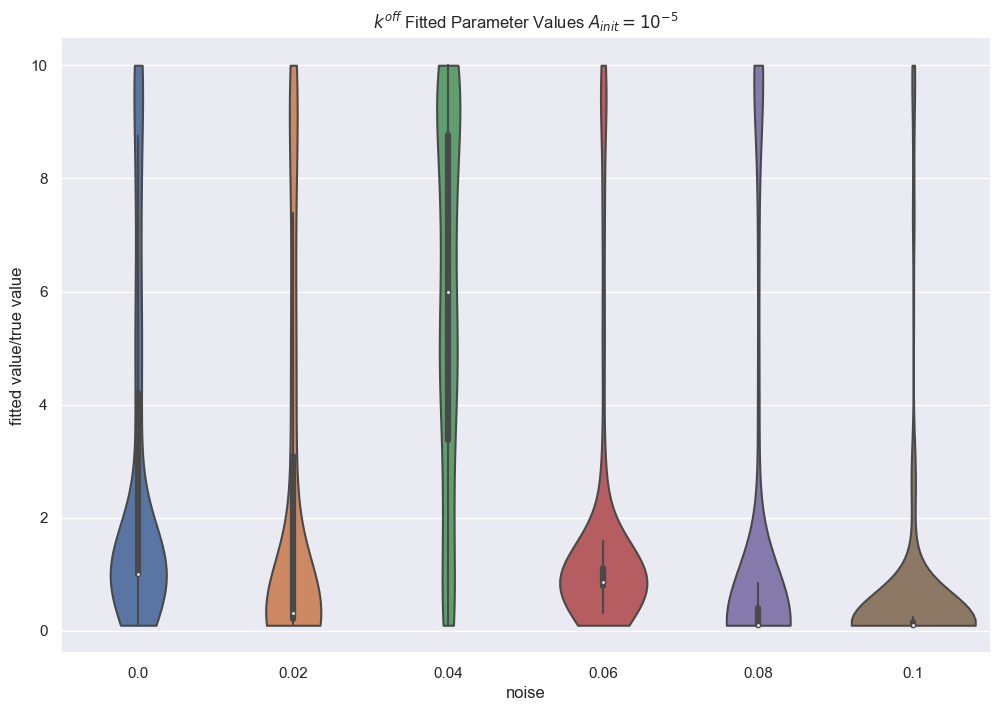

In [415]:
sns.violinplot(data=df, x='noise', y='data', cut=0)
plt.ylabel('fitted value/true value')
plt.title(r'$k^{off}$' + ' Fitted Parameter Values ' + r'$A_{init}=10^{-5}$')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/rtot_fitted_values_distributions.png')

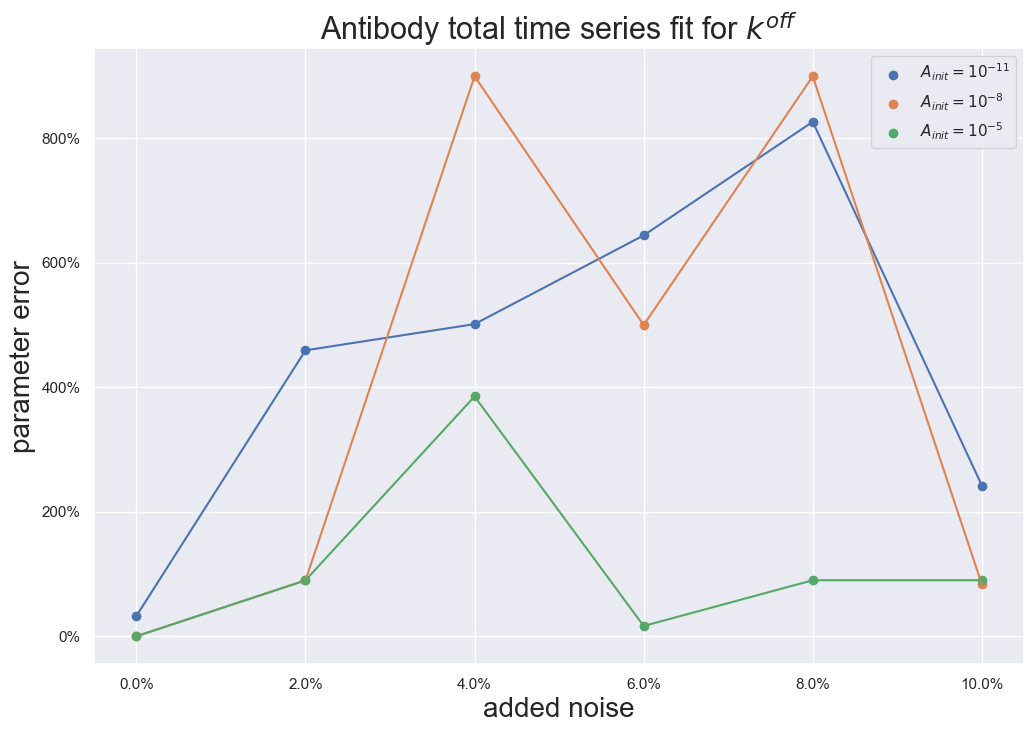

In [226]:
sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.size'] = 100
labels = [r'$A_{init}=10^{-11}$', r'$A_{init}=10^{-8}$', r'$A_{init}=10^{-5}$']

ax = plt.subplot()
for i, label in enumerate(labels):
    ax.scatter(noise_levels, result_vals_best[2][i][:], label = label)
    ax.plot(noise_levels, result_vals_best[2][i][:])

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylabel('parameter error', fontsize = 20 )
plt.title('Antibody total time series fit for ' + r'$k^{off}$', fontsize = 22)
plt.legend()
plt.xlabel('added noise', fontsize = 20)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/synth_data_ab_time_series_rtot1.png')

{'rtot': 259023.1695750368, 'kon': 100000.0, 'k2': 551.2318868763174, 'koff': 0.0005006123456103422}
{'rtot': 100000.00000033267, 'kon': 100000.0, 'k2': 100.00000061176675, 'koff': 0.00010000001335876}
{'rtot': 424284.6492057968, 'kon': 100000.0, 'k2': 196.90059268142733, 'koff': 0.0008079457619921442}
{'rtot': 100233.05777314537, 'kon': 100000.0, 'k2': 186.9147628337103, 'koff': 0.00018990251335306572}
{'rtot': 159697.56056367102, 'kon': 100000.0, 'k2': 202.11473203480216, 'koff': 0.0007967684254816703}
{'rtot': 101258.83002179723, 'kon': 100000.0, 'k2': 189.999999056529, 'koff': 0.00048538601323144234}


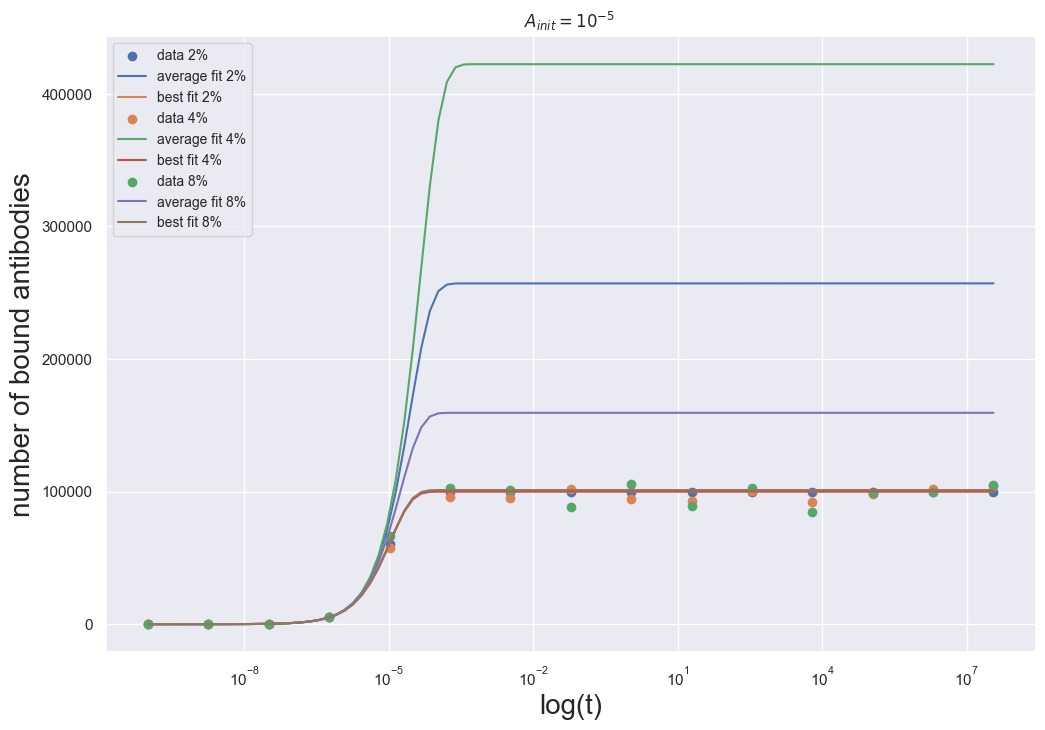

In [227]:
avg_vals = []
best_vals = []
data_vals = []
labels = [f'2%', f'4%', f'8%']
t1 = np.geomspace(1e-10, t_end, 100)
noises = [0.0, 0.04, 0.08]

for i, noise in enumerate(noises):
    rtot_avg = (result_vals_avg[0][0][i]*1e5) + 1e5
    k2_avg = (result_vals_avg[1][0][i]*1e2) + 1e2
    koff_avg = (result_vals_avg[2][0][i]*1e-4) + 1e-4
    params_avg = {f'rtot' : rtot_avg,
          f'kon': 1e5,
          f'k2': k2_avg,
          f'koff': koff_avg}
    print(params_avg)

    rtot_best = (result_vals_best[0][2][i]*1e5) + 1e5
    k2_best = (result_vals_best[1][2][i]*1e2) + 1e2
    koff_best = (result_vals_best[2][2][i]*1e-4) + 1e-4
    params_best = {f'rtot' : rtot_best,
          f'kon': 1e5,
          f'k2': k2_best,
          f'koff': koff_best}
    print(params_best)
    data = data_generator.generate_time_series(1e-5, 'model S', noise)
    data_vals.append(data)



    plt.scatter(t, data, label='data ' + labels[i])

    sol_avg = solve_ode_time(params_avg, 1e-5, t1)
    ab_avg = sol_avg[0] + sol_avg[1]

    sol_best = solve_ode_time(params_best, 1e-5, t1)
    ab_best = sol_best[0] + sol_best[1]
    plt.plot(t1, ab_avg, label='average fit ' + labels[i])
    plt.plot(t1, ab_best, label='best fit ' + labels[i])

plt.xscale('log')
plt.xlabel('log(t)', fontsize = 20)
plt.title(r'$A_{init} = 10^{-5}$ ')
plt.ylabel('number of bound antibodies', fontsize = 20)
plt.legend(fontsize=10)
plt.show()